# WiDS Tokyo@IBM
# 量子機械学習でMNIST分類


Kifumi Numata (Jun 03, 2022)

In [1]:
import numpy as np

# 描画のため
import matplotlib.pyplot as plt

# Scikit-learnのインポート(Python用の機械学習ライブラリー)
from sklearn import datasets
from sklearn.model_selection import train_test_split # データ分割
from sklearn.svm import SVC # SVM Classification(SVM分類)
from sklearn.decomposition import PCA # Principal component analysis(主成分分析)
from sklearn.preprocessing import StandardScaler, MinMaxScaler # 標準化、正規化のスケール変換

# Qiskitのインポート
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

## データを用意

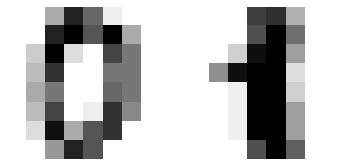

In [2]:
# 数字データセットの読み込み
digits = datasets.load_digits(n_class=2)    # 2クラスのデータをロード

# '0'と'1'の例のプロット
fig, axs = plt.subplots(1, 2, figsize=(6,3))
axs[0].set_axis_off()
axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
axs[1].set_axis_off()
axs[1].imshow(digits.images[1], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

このデータセットには、合計360個のデータポイントが含まれています。各データポイントは、8×8の数字の画像で、配列になっていて、各要素は0（白）から16（黒）までの整数です。古典的な分類アルゴリズムの際と同様に、データセットを学習用（100）とテスト用（20）のサンプルに分割し、正規化する必要があります。このデータセットを量子分類アルゴリズムに用いるためには、範囲を-1から1の間にスケーリングし、次元を使用する量子ビット数（今回は4）に縮小する必要があります。

In [3]:
print(digits.images[0])

[[ 0.  0.  5. 13.  9.  1.  0.  0.]
 [ 0.  0. 13. 15. 10. 15.  5.  0.]
 [ 0.  3. 15.  2.  0. 11.  8.  0.]
 [ 0.  4. 12.  0.  0.  8.  8.  0.]
 [ 0.  5.  8.  0.  0.  9.  8.  0.]
 [ 0.  4. 11.  0.  1. 12.  7.  0.]
 [ 0.  2. 14.  5. 10. 12.  0.  0.]
 [ 0.  0.  6. 13. 10.  0.  0.  0.]]


In [4]:
# データセットの分割
sample_train, sample_test, label_train, label_test = train_test_split(
     digits.data, digits.target, test_size=0.2, random_state=22)

# 次元削除
n_dim = 4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# 標準化
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# 正規化
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# 学習用100個とテスト用20個を選択
train_size = 100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [5]:
# 一つ目のデータをそれぞれ表示
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209] 0
[ 0.41948352 -0.83602799  0.72200828 -0.373356  ] 1


## データ符号化(エンコード)

この古典データを、量子特徴量マップを用いて量子状態空間にエンコードしていきます。さまざまな特徴量マップを表示してみます。

## 特徴量マップの例

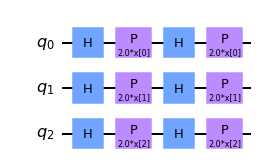

In [6]:
# 4特徴量、深さ(繰り返し数)2のZFeatureMap
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

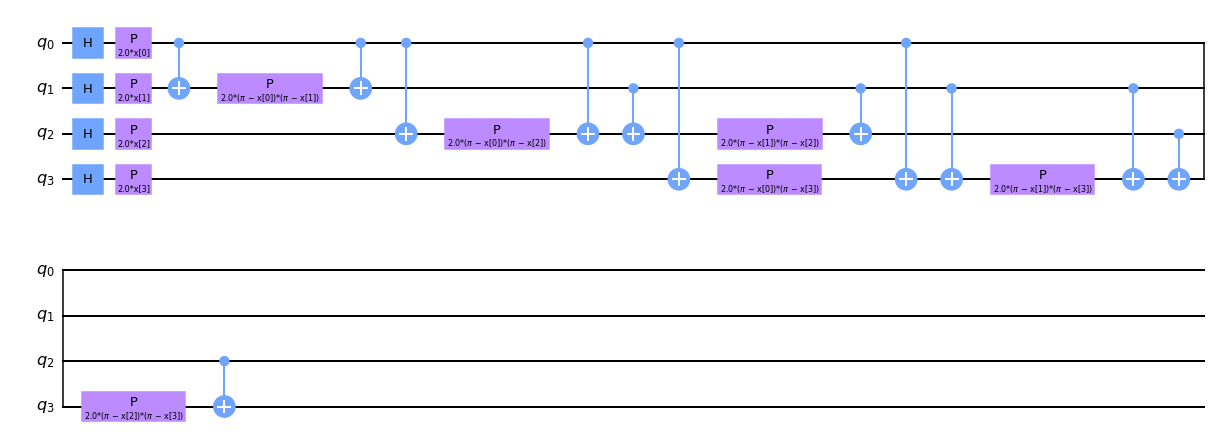

In [7]:
# 4特徴量、深さ(繰り返し数)1のZZFeatureMap
map_zz = ZZFeatureMap(feature_dimension=4, reps=1)
map_zz.decompose().draw('mpl')

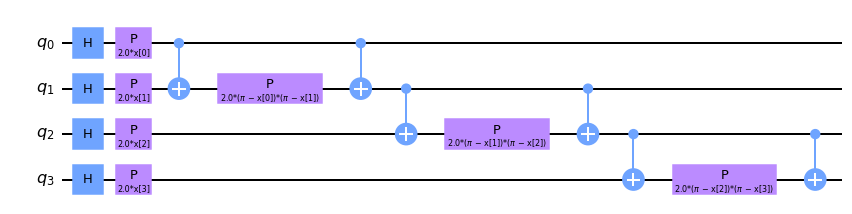

In [8]:
# 4特徴量、深さ(繰り返し数)1、線形量子もつれのZZFeatureMap
map_zz = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

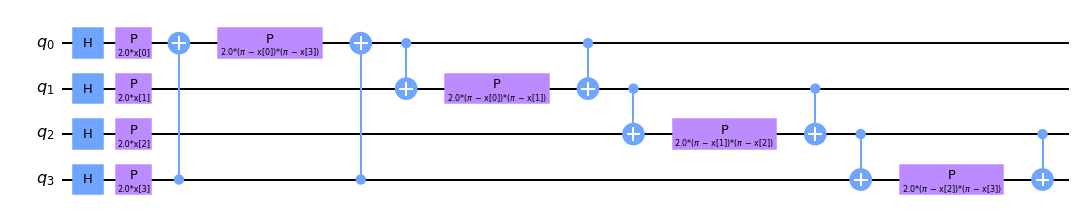

In [9]:
# 4特徴量、深さ(繰り返し数)1、巡回量子もつれのZZFeatureMap
map_zz = ZZFeatureMap(feature_dimension=4, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

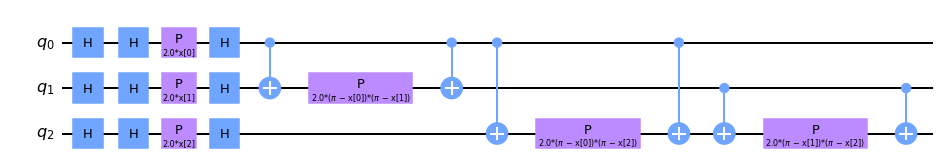

In [10]:
# 3特徴量、深さ(繰り返し数)1のPauliFeatureMap
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'ZZ'])
map_pauli.decompose().draw('mpl')

## 量子カーネル計算

量子特徴マップ$\phi(\vec{x})$は、量子カーネル$k(\vec{x}_i,\vec{x}_j)= \phi(\vec{x}_j)^\dagger\phi(\vec{x}_i)$を作ることができます:それは、これは類似性の尺度と考えることができます。　$\vec{x}_i$ と $\vec{x}_j$が近いときに大きくなります。

今回は、ZZFeatureMapを使って量子カーネルを計算します。

In [11]:
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

訓練データの0個目と1個目のデータについて、量子カーネルを計算する量子回路を作成し、実際に計算してみます。

In [12]:
print(sample_train[0])
print(sample_train[1])

[-0.79923362 -0.26571862 -0.16474421 -0.17815209]
[-0.81630337 -0.2918343  -0.48757339 -0.44903275]


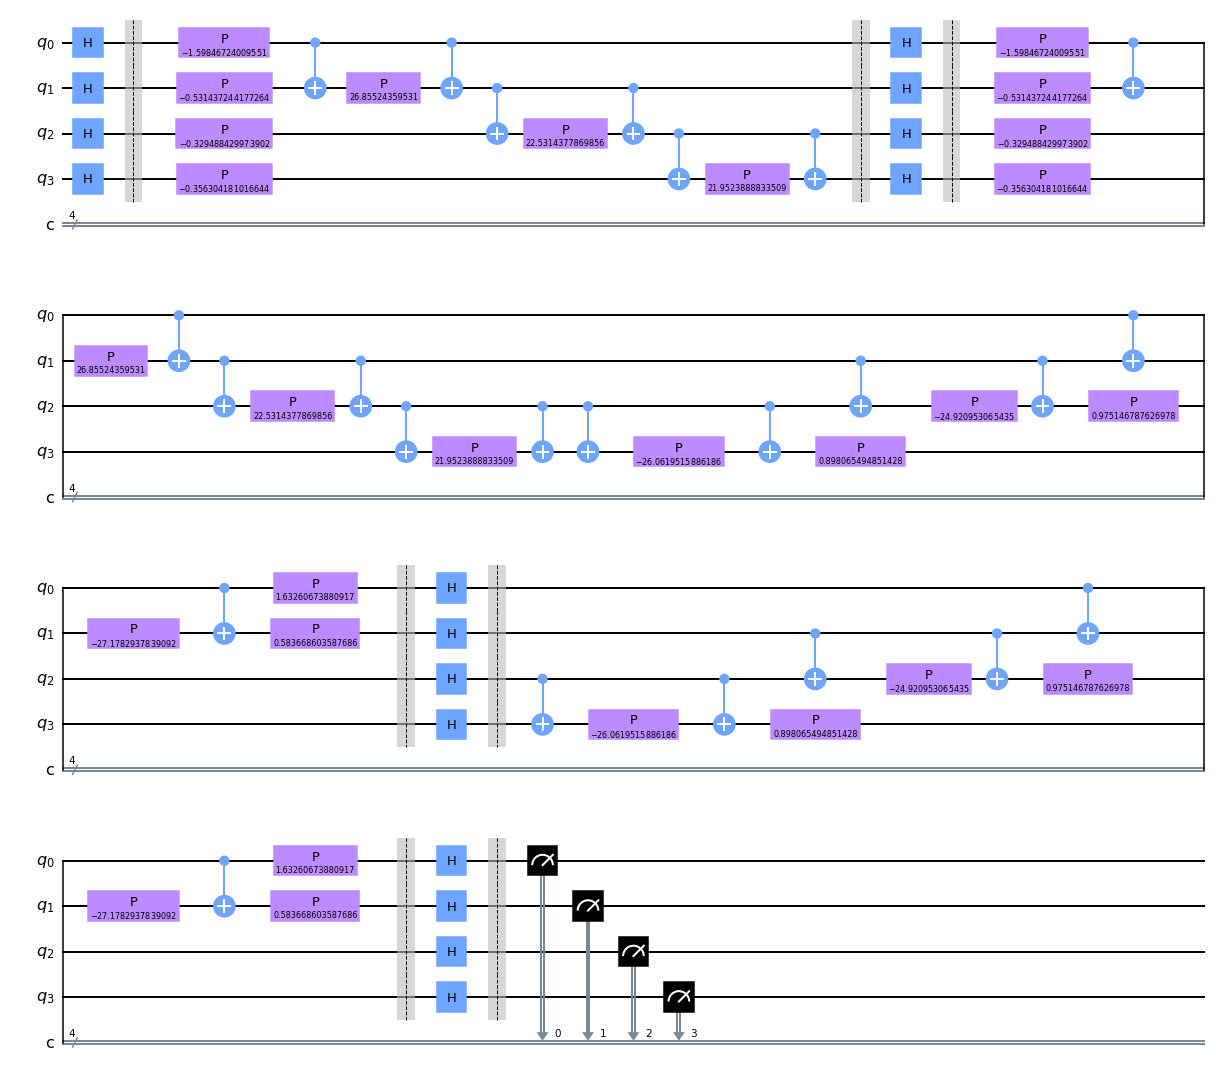

In [13]:
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

各回転ゲートのパラメーター値は少し読みにくいですが、回路が対称になっていることが分かると思います。左半分は訓練データsample_train[0]が、右半分は訓練データsample_train[1]がコード化されています。

例として、上記の量子カーネルを測定し、ゼロ状態のカウント数の割合として、カーネル行列の要素（訓練データの0個目と1個目のデータについて）を計算します。

In [14]:
backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

In [15]:
counts['0000']/sum(counts.values())

0.001953125

このプロセスを，学習データサンプルのペアごとに繰り返して学習カーネル行列を埋め，学習データサンプルとテストデータサンプルの間で繰り返してテストカーネル行列を埋めていきます。なお，各行列は対称形であるため，計算時間を短縮するために，要素の半分だけを計算しています。

訓練データとテストデータについて、QuantumKernelクラスを使ってカーネル行列を計算します。

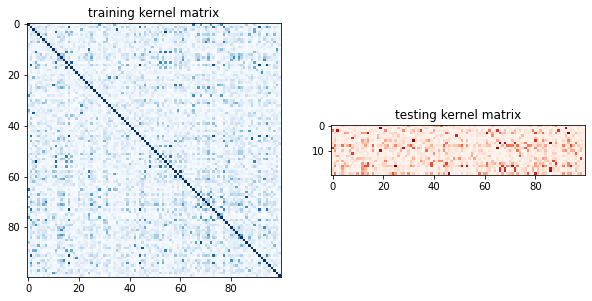

In [16]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

## 学習
古典SVM分類器`scikit-learn`の`svc`アルゴリズムを使って学習し、テストデータで学習率を見てみます。

In [17]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')


Precomputed kernel classification test score: 0.95


テストデータポイントをほぼ正しく分類できていることがわかります。

In [18]:
import qiskit.tools.jupyter
%qiskit_copyright
%qiskit_version_table